In [2]:
import pandas as pd
import numpy as np
import lightgbm as gbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子函数
def set_random_seed(seed):
    np.random.seed(seed)
    import random
    random.seed(seed)

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 划分训练集和测试集，使用固定的random_state确保数据划分一致
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
    
    # 创建随机森林模型，使用当前seed
    clf = gbm.LGBMClassifier(subsample=0.8,  # 行采样（关键参数）
        colsample_bytree=0.8,           # 列采样（关键参数，XGBoost中为colsample_bytree）
        subsample_freq=1,               # 子采样频率（每1轮迭代进行一次采样）
        random_state=seed,              # 随机种子
        deterministic=False,            # 禁用确定性模式（LightGBM 3.3.2+版本）
        force_row_wise=True,            # 强制行级并行（减少全局随机性）
        min_data_in_leaf=20,            # 叶子节点最小样本数（增加稳定性）
    )
    
    # 训练模型并显示进度
    print(f"运行{seed} 训练LightGBM模型...")
    
    # 使用tqdm显示训练进度（模拟）
    with tqdm(total=100, desc=f"运行{seed} 训练进度") as pbar:
        clf.fit(X_train, y_train)
        pbar.update(100)
    
    # 预测
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    # 获取特征重要性
    feature_importance = clf.feature_importances_
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'y_test': y_test,
        'feature_importance': feature_importance,
        'seed': seed
    }

# 读取数据
X = pd.read_csv("E:/comorbidity/models/multi_features/all_features.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")

# 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 标签编码
y = y['标签']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 保存最后一次实验的结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
y_test = final_result['y_test']
feature_importance = final_result['feature_importance']

开始10次独立实验...
运行第1次实验 (seed=42)...
运行42 训练LightGBM模型...


运行42 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行42 训练进度: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第1次: 准确率=0.8113, F1=0.8056
运行第2次实验 (seed=43)...
运行43 训练LightGBM模型...


运行43 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行43 训练进度: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第2次: 准确率=0.8116, F1=0.8061
运行第3次实验 (seed=44)...
运行44 训练LightGBM模型...


运行44 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行44 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第3次: 准确率=0.8112, F1=0.8057
运行第4次实验 (seed=45)...
运行45 训练LightGBM模型...


运行45 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行45 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第4次: 准确率=0.8105, F1=0.8047
运行第5次实验 (seed=46)...
运行46 训练LightGBM模型...


运行46 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行46 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第5次: 准确率=0.8123, F1=0.8067
运行第6次实验 (seed=47)...
运行47 训练LightGBM模型...


运行47 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行47 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第6次: 准确率=0.8117, F1=0.8061
运行第7次实验 (seed=48)...
运行48 训练LightGBM模型...


运行48 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行48 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.93it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第7次: 准确率=0.8125, F1=0.8069
运行第8次实验 (seed=49)...
运行49 训练LightGBM模型...


运行49 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行49 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第8次: 准确率=0.8117, F1=0.8063
运行第9次实验 (seed=50)...
运行50 训练LightGBM模型...


运行50 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行50 训练进度: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第9次: 准确率=0.8104, F1=0.8049
运行第10次实验 (seed=51)...
运行51 训练LightGBM模型...


运行51 训练进度:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Total Bins 197649
[LightGBM] [Info] Number of data points in the train set: 66614, number of used features: 789
[LightGBM] [Info] Start training from score -2.850063
[LightGBM] [Info] Start training from score -0.472836
[LightGBM] [Info] Start training from score -1.443091
[LightGBM] [Info] Start training from score -2.492169


运行51 训练进度: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
第10次: 准确率=0.8116, F1=0.8059

最终结果 (平均值±标准差)
准确率: 0.8115 ± 0.0006
精准率: 0.8068 ± 0.0007
召回率: 0.8115 ± 0.0006
F1值: 0.8059 ± 0.0007
AUC值: 0.9220 ± 0.0006


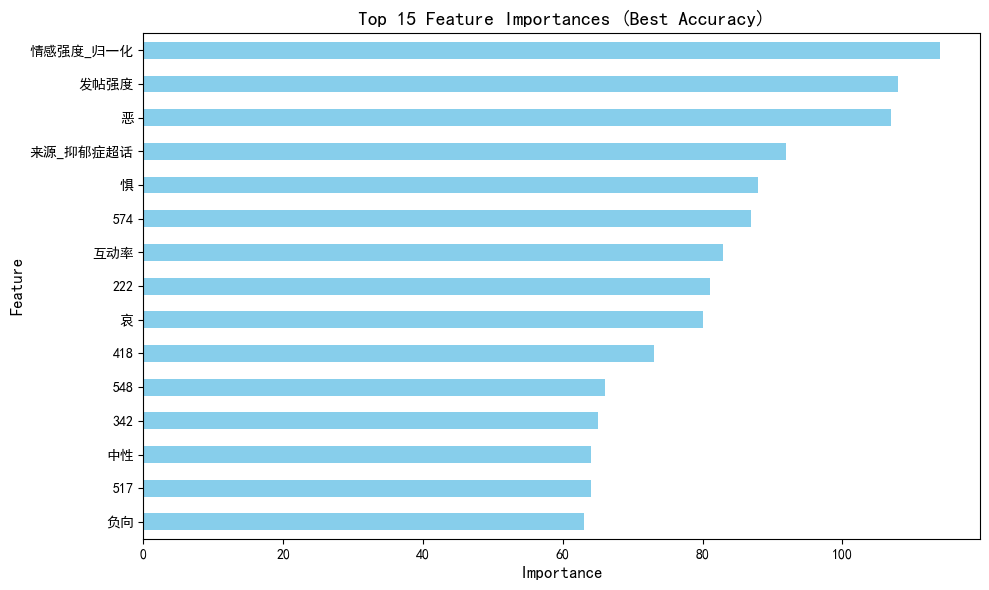

最佳实验准确率: 0.8125, seed=48


In [3]:
# 8. 输出效果最好的一次实验的特征重要性
# 找到准确率最高的那次实验
best_idx = np.argmax([r['accuracy'] for r in results])
best_result = results[best_idx]
best_feature_importance = best_result['feature_importance']

# 可视化
feature_importances = pd.Series(best_feature_importance, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Top 15 Feature Importances (Best Accuracy)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 输出最佳实验的准确率和seed
print(f"最佳实验准确率: {best_result['accuracy']:.4f}, seed={best_result['seed']}")

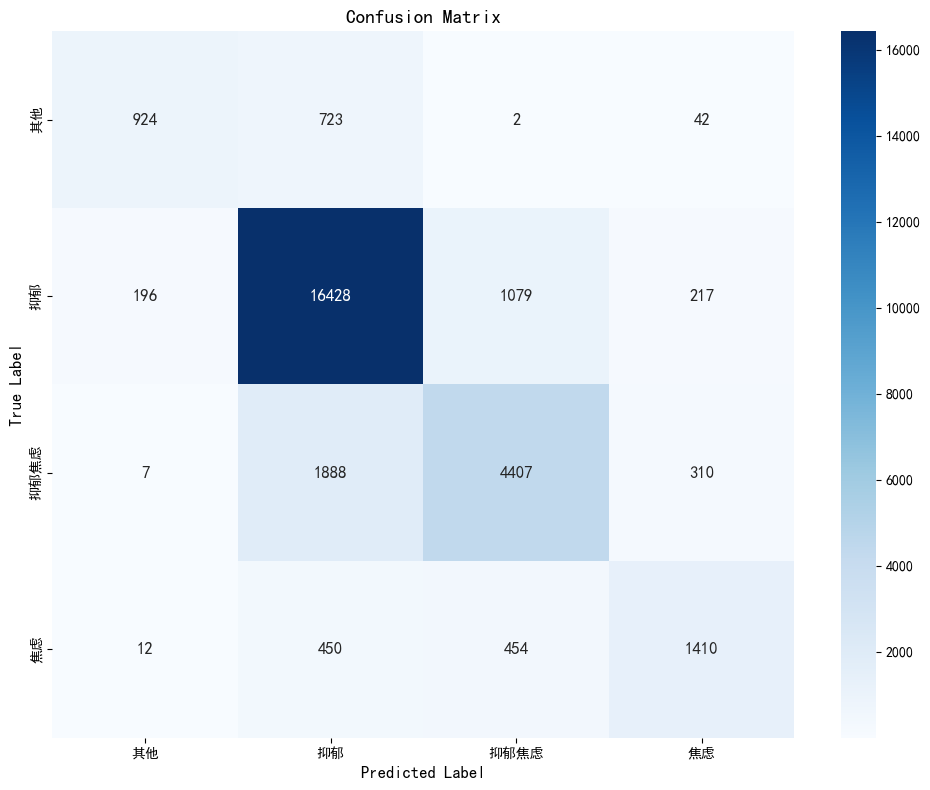

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
# 9. 混淆矩阵可视化
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()


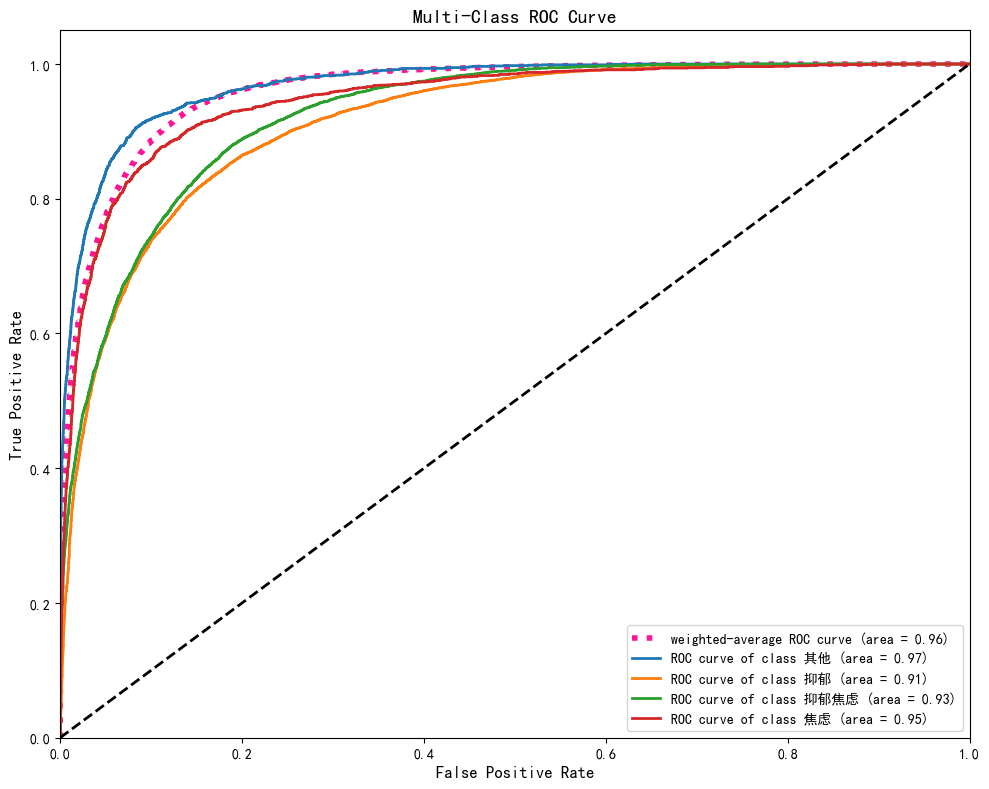

In [5]:
from sklearn.preprocessing import label_binarize

# 多分类ROC曲线可视化
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
